In [61]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)\

import torch
print(torch.__version__)

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import models as model
from torchmetrics import F1Score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

1.11.0


## 1. Data loading
### 1.1 load dataset

In [2]:
# load dataset
# for reproducibility set seed
torch.manual_seed(0)
np.random.seed(0)
# load training data information
train_df = pd.read_csv('COVIDxCXR-2/train.txt',sep=" ",header=None)

# add column name
train_df.columns = ['patient_id','filename','class','data_source']

# only filename and class are needed for image classification
# drop unnecessary columns
train_df = train_df.drop(['patient_id','data_source'], axis=1)

# same for test set
test_df = pd.read_csv('COVIDxCXR-2/test.txt',sep=" ",header=None)
test_df.columns = ['patient_id','filename','class','data_source']
test_df = test_df.drop(['patient_id','data_source'], axis=1)

# get negative values in class column
negative = train_df[train_df['class'] == 'negative']

# get positive values in class column
positive = train_df[train_df['class'] == 'positive']

from sklearn.utils import resample
# we downsample each class to 13990 samples
df_negative_downsampled = resample(negative, replace=True,random_state=0, n_samples = 13990)
df_positive_downsampled = resample(positive, replace=True,random_state=0, n_samples = 13990)

# concatenate
train_df = pd.concat([df_negative_downsampled,df_positive_downsampled])

from sklearn.utils import shuffle
# shuffle the dataset again to randomize it
train_df = shuffle(train_df,random_state=0)

# encode the label to numbers
train_df['class'] = train_df['class'].map({'negative': 0, 'positive': 1})
test_df['class'] = test_df['class'].map({'negative': 0, 'positive': 1})

# split the train data into training and validation dataset
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train_df, train_size=0.9, random_state=0)

In [3]:
#Let's see how many images for training and validation and testing

print(f"Negative and positive values of train: {train_df['class'].value_counts()}")
print(f"Negative and positive values of validation: {valid_df['class'].value_counts()}")
print(f"Negative and positive values of test: {test_df['class'].value_counts()}")

Negative and positive values of train: 1    12623
0    12559
Name: class, dtype: int64
Negative and positive values of validation: 0    1431
1    1367
Name: class, dtype: int64
Negative and positive values of test: 1    200
0    200
Name: class, dtype: int64


In [4]:
# define directory path
train_path = 'COVIDxCXR-2/train'
test_path = 'COVIDxCXR-2/test'

# define function inherited from Dataset class to get data with indices
from torch.utils.data import Dataset
from torchvision.io import read_image,ImageReadMode
from torchvision import transforms
from PIL import Image
class CustomImageDataset(Dataset):
    def __init__(self, data_frame, root_dir, transform=None):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx,0])

        image = Image.open(img_path)
        image = image.convert('RGB')
        label = self.data_frame.iloc[idx,-1]
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
training_data = CustomImageDataset(
    data_frame=train_df,
    root_dir=train_path,
    transform=transforms.Compose([
        
        transforms.Resize([224,224],transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


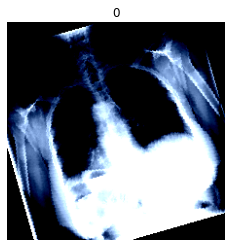

In [6]:
# show sample images
temp_img, temp_label = training_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


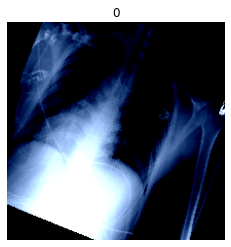

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


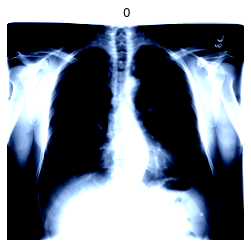

In [7]:
validation_data = CustomImageDataset(
    data_frame=valid_df,
    root_dir=train_path,
    transform=transforms.Compose([
        transforms.Resize([224,224],transforms.InterpolationMode.BICUBIC),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

test_data  = CustomImageDataset(
    data_frame=test_df,
    root_dir=test_path,
    transform=transforms.Compose([
        transforms.Resize([224,244],transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
)

temp_img, temp_label = validation_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

temp_img, temp_label = test_data[253]
plt.imshow(temp_img.numpy().transpose((1,2,0)),cmap='gray')
plt.title(temp_label)
plt.axis('off')
plt.show()

### 1.2 Split dataset

In [8]:
from torch.utils.data import DataLoader
import copy

In [9]:

def covid_iid(dataset, num_users):
    # local dataset num
    num_items = int(len(dataset)/num_users)
    # dict_users -> 所有客户端数据samples的索引字典，all_idxs -> 所有数据samples的索引列表
    dict_users, all_idxs = {},[i for i in range(len(dataset))]
    # 基于clients num执行循环，分配样本
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    
    return dict_users

def covid_noniid(dataset, num_users, imbalance_rate):
    dict_users, all_idxs = {},[i for i in range(len(dataset))]
    positive_idxs,negative_idxs = [],[]
    for i,data_label in enumerate(dataset):
        if data_label[1] == 0:
            negative_idxs.append(i)
        else:
            positive_idxs.append(i)
    print("done enumerate")
    num_total_positive = int(len(negative_idxs)*imbalance_rate/(1-imbalance_rate))
    num_local_positive = int(num_total_positive/num_users)
    num_local_negative = int(len(negative_idxs)/num_users)
    positive_idxs = np.random.choice(positive_idxs, num_total_positive, replace=False)
    print(num_local_positive)
    print(num_local_negative)
    # 基于clients num执行循环，分配样本
    for i in range(num_users):
        # 分配positive样本
        dict_users[i] = set(np.random.choice(positive_idxs, num_local_positive, replace=False))
        positive_idxs = list(set(positive_idxs) - dict_users[i])

        # 分配negative样本
        dict_users[i] = dict_users[i] | set(np.random.choice(negative_idxs, num_local_negative, replace=False))
        negative_idxs = list(set(negative_idxs)-dict_users[i])

    return dict_users

In [10]:
class DatasetSplit(Dataset):
    def __init__(self, dataset,idxs):
        self.dataset = dataset
        self.idxs = list(idxs)
    
    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self,item):
        image,label = self.dataset[self.idxs[item]]
        return image, label
    
class LocalUpdate(object):
    def __init__(self, dataset=None, idxs=None, batch_size=10, local_epoch=10):
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs),batch_size,shuffle=True)
        self.local_epoch = local_epoch
    
    def train(self, net):
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
        
        epoch_loss = []
        
        for iter in range(self.local_epoch):
            batch_loss = []
            for batch_idx, (images,labels) in enumerate(self.ldr_train):
                images = images.to(device)
                labels = labels.to(device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss)/len(epoch_loss)

In [100]:
def test_acc(model,dataset,imbalance_rate,is_test):
    loader = DataLoader(dataset,batch_size=64,shuffle=True,num_workers=0)
    num_correct = 0
    num_samples = 0
    y_true = []
    y_pred = []
    y_true_total = []
    y_pred_total = []
    model.eval()
    model.cuda()
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0
    
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)

            _,predictions = scores.max(1)
            
            y_true = [i.item() for i in y]
            y_pred = [i.item() for i in predictions]
            
            result = (predictions == y)
            result = [i.item() for i in result]
            for i in range(len(result)):
                if result[i] == True:
                    if y_true[i] == 1:
                        true_positive += 1
                    else:
                        true_negative += 1
                    num_correct += 1
                else:
                    if y_true[i] == 1:
                        false_positive += 1
                    else:
                        false_negative += 1
                        
                num_samples += 1
            
            y_true_total.extend(y_true)
            y_pred_total.extend(y_pred)
#             print(y_true_total)
#             print(y_pred_total)
#             print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
#             print('f1_score is ', f1_score(y_true_total,y_pred_total,average='weighted'))
#             return
#             num_correct += (predictions == y).sum()
#             num_samples += predictions.size(0)
        
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
        print('f1_score is ', f1_score(y_true_total,y_pred_total,average='weighted'))
        draw_cf_matrix(y_true_total, y_pred_total,imbalance_rate,is_test)
        
    model.train()
    

In [99]:
def draw_cf_matrix(y_true, y_pred,imbalance_rate,is_test):
    
    cf_matrix = confusion_matrix(y_true, y_pred)
    
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    print(group_counts)
    group_percentage, group_sum = [],[]
    for i in range(2):
        if i < 1:
            group_percentage.extend("{:.2%}".format(value) for value in cf_matrix[0].flatten()/np.sum(cf_matrix[0]))
            total = ["{:.0f}".format(np.sum(cf_matrix[0]))]
            group_sum.extend(total*2)
        else:
            group_percentage.extend("{:.2%}".format(value) for value in cf_matrix[1].flatten()/np.sum(cf_matrix[1]))
            total = ["{:.0f}".format(np.sum(cf_matrix[1]))]
            group_sum.extend(total*2)

    print(group_percentage)
    print(group_sum)
    labels = [f"{v1}\n({v2}/{v3})" for v1, v2, v3 in zip(group_percentage, group_counts, group_sum)]
    print(np.asarray(labels))
    labels = np.asarray(labels).reshape(2,2)
    
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='',cmap='Blues')
    ax.set_title('imbalance_rate = {:.2f}'.format(imbalance_rate))
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    
    if is_test:
        plt.savefig('./save/fed_{}_{}_{}_C{}_{}_noniid_test_confusion_matrix.png'.format("Covid","mobileNet",epochs,frac,imbalance_rate),bbox_inches='tight', pad_inches=0.0,dpi=300)
    else:
        plt.savefig('./save/fed_{}_{}_{}_C{}_{}_noniid_train_confusion_matrix.png'.format("Covid","mobileNet",epochs,frac,imbalance_rate),bbox_inches='tight', pad_inches=0.0,dpi=300)

    
    plt.show()

In [13]:
def FedAvg(w):
    w_avg = copy.deepcopy(w[0])
    
    for k in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[k] += w[i][k]
        w_avg[k] = torch.div(w_avg[k],len(w))
    return w_avg

#### imbalance rate = 0.3
#### reset before every training

In [14]:
# run everytime before new imbalance rate
net_glob_30 = model.mobilenet_v3_small()
net_glob_30.train()
# copy weights
# init global model weight
w_glob_30 = net_glob_30.state_dict()

# training
loss_train_30 = []
cv_loss,cv_acc = [],[]
val_loss_pre, counter = 0,0
net_best = None
best_loss = None
val_acc_list, net_list = [],[]
epochs = 30
total_num_users = 10
frac = 0.4

#### start training

In [18]:
dict_users_30 = covid_noniid(training_data, total_num_users, 0.3)
# imbalance rate = 0.3
for iter in range(epochs):
    loss_locals_30 = []
    
    w_locals_30 = []
    
    max_users_per_training = frac*total_num_users
    # clients sampling
    idxs_users = np.random.choice(range(int(total_num_users)),int(max_users_per_training),replace=False)
    
    for idx in idxs_users:
        # local model train process
        local = LocalUpdate(dataset=training_data, idxs=dict_users_30[idx])
        # w: local model weights
        # loss: corresponding training loss
        w, loss = local.train(net=copy.deepcopy(net_glob_30).to(device))
        w_locals_30.append(copy.deepcopy(w))
        loss_locals_30.append(copy.deepcopy(loss))
        
    
    # update global weights
    w_glob_30 = FedAvg(w_locals_30)
    
    # copy weights to net_glob
    net_glob_30.load_state_dict(w_glob_30)
    
    # print loss
    loss_avg_30 = sum(loss_locals_30)/len(loss_locals_30)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg_30))
    loss_train_30.append(loss_avg_30)

done enumerate
538
1255
Round   0, Average loss 0.453
Round   1, Average loss 0.305
Round   2, Average loss 0.257
Round   3, Average loss 0.197
Round   4, Average loss 0.164
Round   5, Average loss 0.143
Round   6, Average loss 0.128
Round   7, Average loss 0.119
Round   8, Average loss 0.111
Round   9, Average loss 0.101
Round  10, Average loss 0.094
Round  11, Average loss 0.081
Round  12, Average loss 0.084
Round  13, Average loss 0.079
Round  14, Average loss 0.070
Round  15, Average loss 0.071
Round  16, Average loss 0.062
Round  17, Average loss 0.061
Round  18, Average loss 0.056
Round  19, Average loss 0.057
Round  20, Average loss 0.049
Round  21, Average loss 0.047
Round  22, Average loss 0.050
Round  23, Average loss 0.047
Round  24, Average loss 0.042
Round  25, Average loss 0.043
Round  26, Average loss 0.046
Round  27, Average loss 0.041
Round  28, Average loss 0.034
Round  29, Average loss 0.034


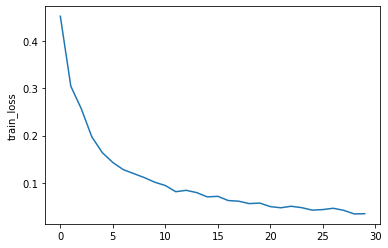

In [19]:
# plot loss curve
plt.figure()
plt.plot(range(len(loss_train_30)),loss_train_30)
plt.ylabel('train_loss')
plt.savefig('./save/fed_{}_{}_{}_C{}_noniid.png'.format("Covid","mobileNet",epochs,frac))



Got 24681 / 25182 with accuracy 98.01
f1_score is  0.9801003137946077
['12515', '44', '457', '12166']
['99.65%', '0.35%', '3.62%', '96.38%']
['12559', '12559', '12623', '12623']
['99.65%\n(12515/12559)' '0.35%\n(44/12559)' '3.62%\n(457/12623)'
 '96.38%\n(12166/12623)']


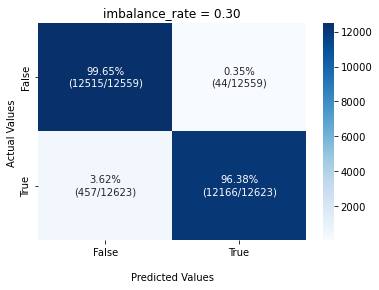

In [98]:
# testing
net_glob_30.eval()
test_acc(net_glob_30, training_data,0.3,0)


Got 363 / 400 with accuracy 90.75
f1_score is  0.9068661074437893
['198', '2', '35', '165']
['99.00%', '1.00%', '17.50%', '82.50%']
['200', '200', '200', '200']
['99.00%\n(198/200)' '1.00%\n(2/200)' '17.50%\n(35/200)'
 '82.50%\n(165/200)']


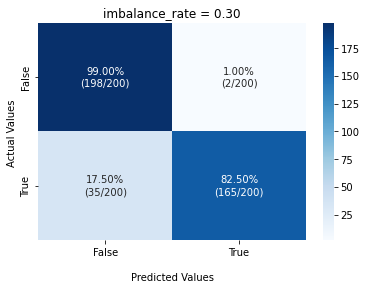

In [101]:
test_acc(net_glob_30, test_data,0.3,1)

#### imbalance rate = 0.05
#### reset before every training

In [58]:
# run everytime before new imbalance rate
net_glob_5 = model.mobilenet_v3_small()
net_glob_5.train()
# copy weights
# init global model weight
w_glob_5 = net_glob_5.state_dict()

# training
loss_train_5 = []
epochs = 30
total_num_users = 10
frac = 0.4

In [59]:
dict_users_5 = covid_noniid(training_data, total_num_users, 0.05)
# imbalance rate = 0.05
for iter in range(epochs):
    loss_locals_5 = []
    
    w_locals_5 = []
    
    max_users_per_training = frac*total_num_users
    # clients sampling
    idxs_users = np.random.choice(range(int(total_num_users)),int(max_users_per_training),replace=False)
    
    for idx in idxs_users:
        # local model train process
        local = LocalUpdate(dataset=training_data, idxs=dict_users_5[idx])
        # w: local model weights
        # loss: corresponding training loss
        w, loss = local.train(net=copy.deepcopy(net_glob_5).to(device))
        w_locals_5.append(copy.deepcopy(w))
        loss_locals_5.append(copy.deepcopy(loss))
        
    
    # update global weights
    w_glob_5 = FedAvg(w_locals_5)
    
    # copy weights to net_glob
    net_glob_5.load_state_dict(w_glob_5)
    
    # print loss
    loss_avg_5 = sum(loss_locals_5)/len(loss_locals_5)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg_5))
    loss_train_5.append(loss_avg_5)

done enumerate
66
1255
Round   0, Average loss 0.254
Round   1, Average loss 0.139
Round   2, Average loss 0.119
Round   3, Average loss 0.101
Round   4, Average loss 0.092
Round   5, Average loss 0.083
Round   6, Average loss 0.073
Round   7, Average loss 0.070
Round   8, Average loss 0.058
Round   9, Average loss 0.051
Round  10, Average loss 0.051
Round  11, Average loss 0.054
Round  12, Average loss 0.044
Round  13, Average loss 0.045
Round  14, Average loss 0.042
Round  15, Average loss 0.040
Round  16, Average loss 0.035
Round  17, Average loss 0.038
Round  18, Average loss 0.033
Round  19, Average loss 0.034
Round  20, Average loss 0.032
Round  21, Average loss 0.034
Round  22, Average loss 0.030
Round  23, Average loss 0.029
Round  24, Average loss 0.030
Round  25, Average loss 0.026
Round  26, Average loss 0.025
Round  27, Average loss 0.027
Round  28, Average loss 0.024
Round  29, Average loss 0.025


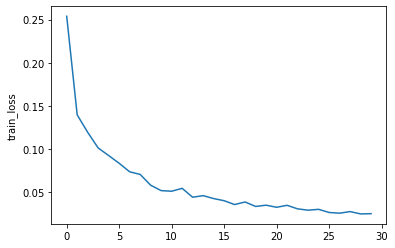

In [91]:
# plot loss curve
plt.figure()
plt.plot(range(len(loss_train_5)),loss_train_5)
plt.ylabel('train_loss')
plt.savefig('./save/fed_{}_{}_{}_C{}_noniid.png'.format("Covid","mobileNet",epochs,frac))


Got 21888 / 25182 with accuracy 86.92
f1_score is  0.8669802832445331
['12552', '7', '3287', '9336']
['99.94%', '0.06%', '26.04%', '73.96%']
['12559', '12559', '12623', '12623']
['99.94%\n(12552/12559)' '0.06%\n(7/12559)' '26.04%\n(3287/12623)'
 '73.96%\n(9336/12623)']


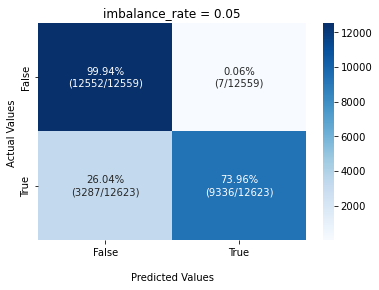

In [102]:
# testing
net_glob_5.eval()
test_acc(net_glob_5, training_data,0.05,0)

Got 240 / 400 with accuracy 60.00
f1_score is  0.5238095238095238
['200', '0', '160', '40']
['100.00%', '0.00%', '80.00%', '20.00%']
['200', '200', '200', '200']
['100.00%\n(200/200)' '0.00%\n(0/200)' '80.00%\n(160/200)'
 '20.00%\n(40/200)']


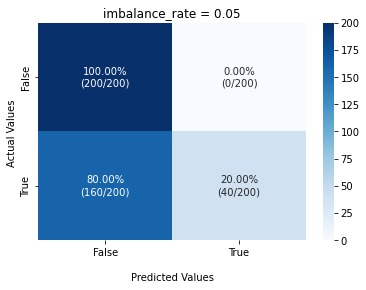

In [103]:
test_acc(net_glob_5, test_data,0.05,1)

#### imbalance rate = 0.1
#### reset before training

In [104]:
# run everytime before new imbalance rate
net_glob_10 = model.mobilenet_v3_small()
net_glob_10.train()
# copy weights
# init global model weight
w_glob_10 = net_glob_10.state_dict()

# training
loss_train_10 = []
epochs = 30
total_num_users = 10
frac = 0.4

In [105]:
dict_users_10 = covid_noniid(training_data, total_num_users, 0.1)
# imbalance rate = 0.10
for iter in range(epochs):
    loss_locals_10 = []
    
    w_locals_10 = []
    
    max_users_per_training = frac*total_num_users
    # clients sampling
    idxs_users = np.random.choice(range(int(total_num_users)),int(max_users_per_training),replace=False)
    
    for idx in idxs_users:
        # local model train process
        local = LocalUpdate(dataset=training_data, idxs=dict_users_10[idx])
        # w: local model weights
        # loss: corresponding training loss
        w, loss = local.train(net=copy.deepcopy(net_glob_10).to(device))
        w_locals_10.append(copy.deepcopy(w))
        loss_locals_10.append(copy.deepcopy(loss))
        
    
    # update global weights
    w_glob_10 = FedAvg(w_locals_10)
    
    # copy weights to net_glob
    net_glob_10.load_state_dict(w_glob_10)
    
    # print loss
    loss_avg_10 = sum(loss_locals_10)/len(loss_locals_10)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg_10))
    loss_train_10.append(loss_avg_10)

done enumerate
139
1255
Round   0, Average loss 0.328
Round   1, Average loss 0.204
Round   2, Average loss 0.174
Round   3, Average loss 0.149
Round   4, Average loss 0.128
Round   5, Average loss 0.104
Round   6, Average loss 0.098
Round   7, Average loss 0.082
Round   8, Average loss 0.075
Round   9, Average loss 0.068
Round  10, Average loss 0.074
Round  11, Average loss 0.070
Round  12, Average loss 0.065
Round  13, Average loss 0.058
Round  14, Average loss 0.056
Round  15, Average loss 0.050
Round  16, Average loss 0.053
Round  17, Average loss 0.046
Round  18, Average loss 0.041
Round  19, Average loss 0.043
Round  20, Average loss 0.036
Round  21, Average loss 0.040
Round  22, Average loss 0.033
Round  23, Average loss 0.037
Round  24, Average loss 0.034
Round  25, Average loss 0.031
Round  26, Average loss 0.027
Round  27, Average loss 0.026
Round  28, Average loss 0.032
Round  29, Average loss 0.024


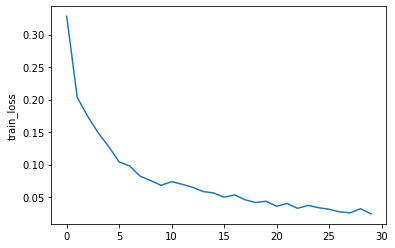

In [106]:
# plot loss curve
plt.figure()
plt.plot(range(len(loss_train_10)),loss_train_10)
plt.ylabel('train_loss')
plt.savefig('./save/fed_{}_{}_{}_C{}_noniid.png'.format("Covid","mobileNet",epochs,frac))

Got 24147 / 25182 with accuracy 95.89
f1_score is  0.958841077443888
['12531', '28', '1007', '11616']
['99.78%', '0.22%', '7.98%', '92.02%']
['12559', '12559', '12623', '12623']
['99.78%\n(12531/12559)' '0.22%\n(28/12559)' '7.98%\n(1007/12623)'
 '92.02%\n(11616/12623)']


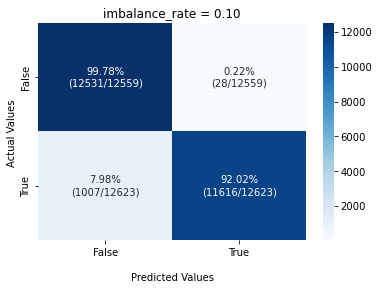

In [107]:
# testing
net_glob_10.eval()                                                                                                                                                              .eval()
test_acc(net_glob_10, training_data,0.1,0)

Got 319 / 400 with accuracy 79.75
f1_score is  0.7901214574898785
['197', '3', '78', '122']
['98.50%', '1.50%', '39.00%', '61.00%']
['200', '200', '200', '200']
['98.50%\n(197/200)' '1.50%\n(3/200)' '39.00%\n(78/200)'
 '61.00%\n(122/200)']


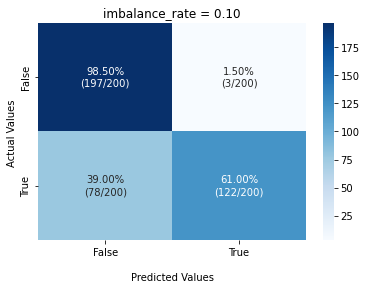

In [108]:
test_acc(net_glob_10, test_data,0.1,1)

#### imbalance rate = 0.15
#### reset before training

In [109]:
# run everytime before new imbalance rate
net_glob_15 = model.mobilenet_v3_small()
net_glob_15.train()
# copy weights
# init global model weight
w_glob_15 = net_glob_15.state_dict()

# training
loss_train_15 = []
epochs = 30
total_num_users = 10
frac = 0.4

In [110]:
dict_users_15 = covid_noniid(training_data, total_num_users, 0.15)
# imbalance rate = 0.15
for iter in range(epochs):
    loss_locals_15 = []
    
    w_locals_15 = []
    
    max_users_per_training = frac*total_num_users
    # clients sampling
    idxs_users = np.random.choice(range(int(total_num_users)),int(max_users_per_training),replace=False)
    
    for idx in idxs_users:
        # local model train process
        local = LocalUpdate(dataset=training_data, idxs=dict_users_15[idx])
        # w: local model weights
        # loss: corresponding training loss
        w, loss = local.train(net=copy.deepcopy(net_glob_15).to(device))
        w_locals_15.append(copy.deepcopy(w))
        loss_locals_15.append(copy.deepcopy(loss))
        
    
    # update global weights
    w_glob_15 = FedAvg(w_locals_15)
    
    # copy weights to net_glob
    net_glob_15.load_state_dict(w_glob_15)
    
    # print loss
    loss_avg_15 = sum(loss_locals_15)/len(loss_locals_15)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg_15))
    loss_train_15.append(loss_avg_15)

done enumerate
221
1255
Round   0, Average loss 0.376
Round   1, Average loss 0.246
Round   2, Average loss 0.207
Round   3, Average loss 0.172
Round   4, Average loss 0.143
Round   5, Average loss 0.127
Round   6, Average loss 0.109
Round   7, Average loss 0.102
Round   8, Average loss 0.097
Round   9, Average loss 0.079
Round  10, Average loss 0.078
Round  11, Average loss 0.072
Round  12, Average loss 0.062
Round  13, Average loss 0.060
Round  14, Average loss 0.051
Round  15, Average loss 0.052
Round  16, Average loss 0.050
Round  17, Average loss 0.053
Round  18, Average loss 0.042
Round  19, Average loss 0.042
Round  20, Average loss 0.041
Round  21, Average loss 0.040
Round  22, Average loss 0.038
Round  23, Average loss 0.038
Round  24, Average loss 0.033
Round  25, Average loss 0.031
Round  26, Average loss 0.031
Round  27, Average loss 0.032
Round  28, Average loss 0.028
Round  29, Average loss 0.028


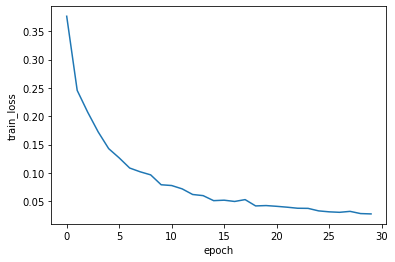

In [112]:
# plot loss curve
plt.figure()
plt.plot(range(len(loss_train_15)),loss_train_15)
plt.ylabel('train_loss')
plt.xlabel('epoch')
plt.savefig('./save/fed_{}_{}_{}_C{}_0.15_noniid.png'.format("Covid","mobileNet",epochs,frac))

Got 24320 / 25182 with accuracy 96.58
f1_score is  0.9657432386221505
['12491', '68', '794', '11829']
['99.46%', '0.54%', '6.29%', '93.71%']
['12559', '12559', '12623', '12623']
['99.46%\n(12491/12559)' '0.54%\n(68/12559)' '6.29%\n(794/12623)'
 '93.71%\n(11829/12623)']


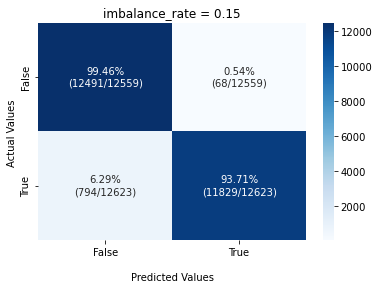

In [113]:
# testing
net_glob_15.eval()
test_acc(net_glob_15, training_data,0.15,0)

Got 332 / 400 with accuracy 83.00
f1_score is  0.8252422194238135
['199', '1', '67', '133']
['99.50%', '0.50%', '33.50%', '66.50%']
['200', '200', '200', '200']
['99.50%\n(199/200)' '0.50%\n(1/200)' '33.50%\n(67/200)'
 '66.50%\n(133/200)']


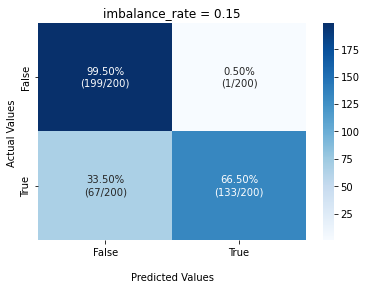

In [114]:
test_acc(net_glob_15, test_data, 0.15,1)

#### imbalance rate = 0.20
#### reset before training

In [115]:
# run everytime before new imbalance rate
net_glob_20 = model.mobilenet_v3_small()
net_glob_20.train()
# copy weights
# init global model weight
w_glob_20 = net_glob_20.state_dict()

# training
loss_train_20 = []
epochs = 30
total_num_users = 10
frac = 0.4

In [116]:
dict_users_20 = covid_noniid(training_data, total_num_users, 0.2)
# imbalance rate = 0.20
for iter in range(epochs):
    loss_locals_20 = []
    
    w_locals_20 = []
    
    max_users_per_training = frac*total_num_users
    # clients sampling
    idxs_users = np.random.choice(range(int(total_num_users)),int(max_users_per_training),replace=False)
    
    for idx in idxs_users:
        # local model train process
        local = LocalUpdate(dataset=training_data, idxs=dict_users_20[idx])
        # w: local model weights
        # loss: corresponding training loss
        w, loss = local.train(net=copy.deepcopy(net_glob_20).to(device))
        w_locals_20.append(copy.deepcopy(w))
        loss_locals_20.append(copy.deepcopy(loss))
        
    
    # update global weights
    w_glob_20 = FedAvg(w_locals_20)
    
    # copy weights to net_glob
    net_glob_20.load_state_dict(w_glob_20)
    
    # print loss
    loss_avg_20 = sum(loss_locals_20)/len(loss_locals_20)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg_20))
    loss_train_20.append(loss_avg_20)

done enumerate
313
1255
Round   0, Average loss 0.408
Round   1, Average loss 0.268
Round   2, Average loss 0.213
Round   3, Average loss 0.177
Round   4, Average loss 0.148
Round   5, Average loss 0.129
Round   6, Average loss 0.111
Round   7, Average loss 0.106
Round   8, Average loss 0.086
Round   9, Average loss 0.084
Round  10, Average loss 0.088
Round  11, Average loss 0.069
Round  12, Average loss 0.067
Round  13, Average loss 0.058
Round  14, Average loss 0.056
Round  15, Average loss 0.062
Round  16, Average loss 0.053
Round  17, Average loss 0.050
Round  18, Average loss 0.049
Round  19, Average loss 0.044
Round  20, Average loss 0.043
Round  21, Average loss 0.040
Round  22, Average loss 0.047
Round  23, Average loss 0.037
Round  24, Average loss 0.032
Round  25, Average loss 0.036
Round  26, Average loss 0.039
Round  27, Average loss 0.036
Round  28, Average loss 0.031
Round  29, Average loss 0.028


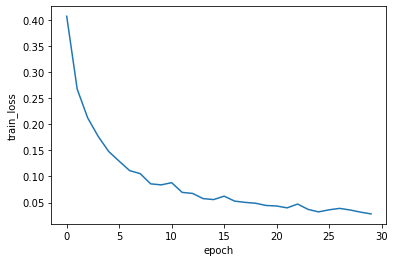

In [117]:
# plot loss curve
plt.figure()
plt.plot(range(len(loss_train_20)),loss_train_20)
plt.ylabel('train_loss')
plt.xlabel('epoch')
plt.savefig('./save/fed_{}_{}_{}_C{}_0.20_noniid.png'.format("Covid","mobileNet",epochs,frac))

Got 24577 / 25182 with accuracy 97.60
f1_score is  0.9759668174401986
['12504', '55', '550', '12073']
['99.56%', '0.44%', '4.36%', '95.64%']
['12559', '12559', '12623', '12623']
['99.56%\n(12504/12559)' '0.44%\n(55/12559)' '4.36%\n(550/12623)'
 '95.64%\n(12073/12623)']


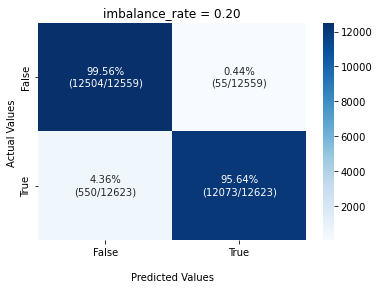

In [118]:
# testing
net_glob_20.eval()
test_acc(net_glob_20, training_data,0.20,0)

Got 339 / 400 with accuracy 84.75
f1_score is  0.8445612358655836
['197', '3', '58', '142']
['98.50%', '1.50%', '29.00%', '71.00%']
['200', '200', '200', '200']
['98.50%\n(197/200)' '1.50%\n(3/200)' '29.00%\n(58/200)'
 '71.00%\n(142/200)']


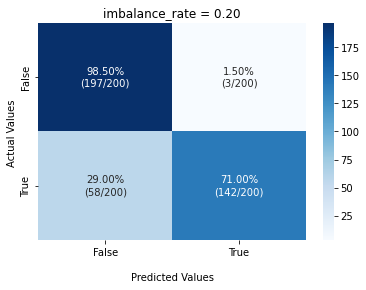

In [120]:
test_acc(net_glob_20, test_data, 0.20,1)